In [5]:
import pandas as pd
import time

data = pd.read_json("https://data.nsw.gov.au/data/api/3/action/datastore_search?resource_id=2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa&limit=6000")
data = pd.json_normalize(data.result.records)
data = data[["notification_date", "lga_code19", ""]]
data.columns = ["date", "code"]
data.date = pd.to_datetime(data.date)
data["cases"] = [1] * len(data)
data.describe(datetime_is_numeric=True)
data = data.groupby(["date", "code"]).sum().reset_index()
data.code = data.code.astype("int")
data.dropna(inplace=True)
data.sort_values("date", inplace=True)

act_data = pd.read_csv("./actCases.csv")
act_data.date = pd.to_datetime(act_data.date, format="%d/%m/%Y")
act_data["code"] = 89399

data = pd.concat([data, act_data], ignore_index=True)
date_start = data.date.min()
date_end = data.date.max()
date_length = (date_end - date_start).days

data_chart = pd.DataFrame(columns=["date", "code", "cases"])

count = 0
print("date being processed:")
while date_start + pd.Timedelta(count, unit="d") <= date_end:
    date_current = date_start + pd.Timedelta(count, unit="d")    
    print(date_current, end="\r")
    for code in data.code.unique():
        data_temp = data[(data.date == date_current) & (data.code == code)]
        if len(data_temp) == 0:
            data_chart.loc[len(data_chart)] = [date_current, code, 0]
        else:
            data_chart.loc[len(data_chart)] = [date_current, code, data_temp.iat[0, 2]]
    count = count + 1
print("date processing completed")

timer = time.time()
interval = 1
print("processing recent cases ...", end="\r")
for i, indice in enumerate(data_chart.index):
    data_temp = data_chart[(data_chart.code == data_chart.at[indice, "code"]) & (data_chart.date > data_chart.at[indice, "date"] - pd.Timedelta("14 days")) & (data_chart.date <= data_chart.at[indice, "date"])]
    data_chart.at[indice, "recent"] = data_temp.cases.sum()
    if time.time() - interval > timer:
        interval = interval + 1
        print(f"processing recent cases ... {(i + 1) / len(data_chart):.1%}", end="\r")
print("processing recent cases ... complete")

data_chart
data_chart.to_csv("./cases.csv", index=False)

date being processed:
date processing completed
processing recent cases ... complete


<AxesSubplot:xlabel='date'>

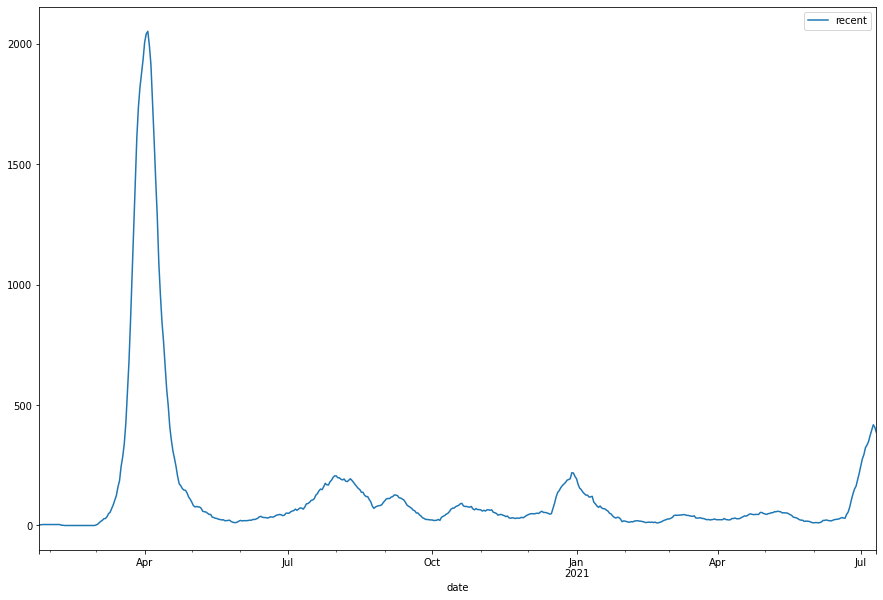

In [9]:
data_chart.groupby("date").sum().plot(figsize=(15, 10))